In [53]:
import os
from shutil import copyfile, rmtree

import PIL
from PIL import ImageDraw
PIL.PILLOW_VERSION = PIL.__version__

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [54]:
data_dir = "./games_enhanced"

# Setup Data

## Collect the position csv for every game

In [55]:
df = pd.DataFrame(columns=["image_name", "tags"])
for g in os.listdir("./games"):
    try:
        game_df = pd.read_csv(f'./games/{g}/full/full_{g}.csv')
        df = df.append(game_df)
    except:
        pass

## Cleanup the dataframe

In [56]:
actual = os.listdir("./games_enhanced")
actual = [a.replace(".png", "") for a in actual]
composites = {}
for a in actual:
    composites[a] = True

df = df.sort_values(by=['image_name'])
df = df[df['image_name'].isin(actual)]
df[:3]

,image_name,tags
108,ahq_dwg_1_worlds_oct_13_2019_0000000000,3;3;blue 3;4;blue 4;2;red 4;4;blue 4;5;blue 5;...
755,ahq_dwg_1_worlds_oct_13_2019_0000000001,3;3;blue 3;4;blue 4;2;red 4;4;blue 4;5;blue 5;...
647,ahq_dwg_1_worlds_oct_13_2019_0000000002,2;4;blue 3;2;red 3;4;blue 4;2;red 4;5;blue 5;3...


## Invert Colours for Top Maps

In [57]:
game_locations = {}
team_location_df = pd.read_csv('./games/team_location.csv')
for row in team_location_df.itertuples():
    game_locations[row[1]] = row[2]

new_data = [[]]*len(df)

i = 0
for row in df.itertuples():
    game_name = "_".join(row.image_name.split("_")[:-1])
    game_position = game_locations[game_name]
    tags = row.tags
    if game_position == "top":
        tags = tags.replace("red","b") 
        tags = tags.replace("blue","r")
    tags = tags.replace("red","r") 
    tags = tags.replace("blue","b")
    new_data[i] = (row[1], tags)
    i += 1

new_df = pd.DataFrame(new_data, columns=["image_name", "tags"])
new_df

,image_name,tags
0,ahq_dwg_1_worlds_oct_13_2019_0000000000,3;3;r 3;4;r 4;2;b 4;4;r 4;5;r 5;3;b 5;4;b 5;5;...
1,ahq_dwg_1_worlds_oct_13_2019_0000000001,3;3;r 3;4;r 4;2;b 4;4;r 4;5;r 5;3;b 5;4;b 5;5;...
2,ahq_dwg_1_worlds_oct_13_2019_0000000002,2;4;r 3;2;b 3;4;r 4;2;b 4;5;r 5;3;b 5;4;b 5;5;...
3,ahq_dwg_1_worlds_oct_13_2019_0000000003,2;4;r 3;2;b 3;3;r 3;4;r 4;2;b 4;4;r 4;5;r 5;3;...
4,ahq_dwg_1_worlds_oct_13_2019_0000000004,3;3;r 3;4;r 4;2;b 4;4;r 4;5;r 5;3;b 5;4;b 5;5;...
...,...,...
176823,spy_uol_6_2019_0000001595,7;3;b 7;4;b 8;3;b 8;4;r 9;4;r
176824,spy_uol_6_2019_0000001596,6;4;r 7;3;b 8;3;b 8;4;r
176825,spy_uol_6_2019_0000001597,7;3;b 7;4;r
176826,spy_uol_6_2019_0000001598,6;3;r 7;3;r 7;4;r


# Train the Model

## Setup the Databatch

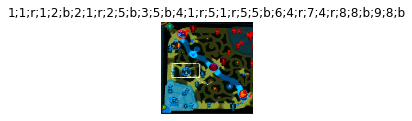

In [61]:
res = []
res.append(symmetric_warp(magnitude=(-0.1,0.1), p=0.75))
res.append(rotate(degrees=(-2.,2.), p=0.75))
res.append(rand_zoom(scale=(1.,1.1), p=0.75))
res.append(brightness(change=(0.5*(1-0.4), 0.5*(1+0.8)), p=0.75))
res.append(contrast(scale=(1-0.2, 1/(1-0.2)), p=0.75))
res.append(jitter(magnitude=(-0.005,0.005))) # Very big increase in the effectiveness of actual phone predictions.

# Did not increase accuracy and did not improve end results
# res.append(cutout(n_holes=(1,3), length=(30, 50), p=1.))

tfms = (res, [])

src = (ImageList.from_df(new_df, "./games_enhanced", suffix=".png", cols=0)
                .split_by_idx(range(0,len(df)//5))
                .label_from_df(label_delim=' ', cols=1))

data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms, size=300, bs=64)

data.show_batch(rows=1)

## Train

In [90]:
learn = None
gc.collect()

thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
learn = create_cnn(data, models.resnet50, metrics=[acc_02])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]

In [65]:
lr = 0.02
learn.fit_one_cycle(1, lr)
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.129598,0.118788,0.941964,09:20


Better model found at epoch 0 with valid_loss value: 0.11878824234008789.


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.126870,0.115751,0.943282,12:15
1,0.123628,0.113372,0.945902,12:16
2,0.120723,0.111728,0.943702,12:17
3,0.119400,0.109639,0.946936,12:18
4,0.117364,0.107781,0.948344,12:18
5,0.113833,0.106023,0.949320,12:19
6,0.112092,0.106001,0.951686,12:19
7,0.111233,0.104662,0.950451,12:20
8,0.108387,0.104481,0.949765,12:20
9,0.106928,0.103824,0.948262,12:21


Better model found at epoch 0 with valid_loss value: 0.11575149744749069.
Better model found at epoch 1 with valid_loss value: 0.11337203532457352.
Better model found at epoch 2 with valid_loss value: 0.11172807961702347.
Better model found at epoch 3 with valid_loss value: 0.1096394881606102.
Better model found at epoch 4 with valid_loss value: 0.10778070241212845.
Better model found at epoch 5 with valid_loss value: 0.10602319240570068.
Better model found at epoch 6 with valid_loss value: 0.10600067675113678.
Better model found at epoch 7 with valid_loss value: 0.10466159880161285.
Better model found at epoch 8 with valid_loss value: 0.10448058694601059.
Better model found at epoch 9 with valid_loss value: 0.10382375121116638.
Better model found at epoch 10 with valid_loss value: 0.10357561707496643.
Better model found at epoch 11 with valid_loss value: 0.10295134037733078.
Better model found at epoch 13 with valid_loss value: 0.10281839966773987.


### Results
* resnet50 bs:64 (10, slice(1e-5, lr/5))          0.102783 	0.104214
* resnet50 bs:64 (10, slice(1e-5, lr/5))          0.102492 	0.104032  Added Jitter 
* resnet34 size:300 bs:30 (15, slice(1e-5, lr/5)) 0.102622 	0.101885
* resnet50 size:300 bs:30 (12, slice(1e-5, lr/5)) 0.102622 	0.100925
* resnet18 size:300 bs:64 (12, slice(1e-5, lr/5)) 0.104122 	0.102613 	
* resnet18 size:300 bs:64 (12, slice(1e-5, lr/5)) 0.100771 	0.102818 

In [78]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/home/isaac/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py", line 75, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


In [67]:
grid_size = 15
def draw_grid(draw, labels):
    for l in labels:
        x = l[0]*grid_size
        y = l[1]*grid_size
        fill = (255, 0, 0, 96)
        if l[2] == "b":
            fill = (0, 0, 255, 96)
        draw.rectangle((x-7, y-7, x + 8, y + 8), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    
    classes = [(int(c.split(";")[0]), int(c.split(";")[1]), c.split(";")[2]) for c in classes]

    filename = learn.data.valid_ds.items[index]
    
    img = PIL.Image.open(filename).convert("RGBA")
    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    full_name = filename.split("/")[-1]
    full_name = "./games_collected/full/"+full_name
    img = PIL.Image.open(full_name)
    process(img)

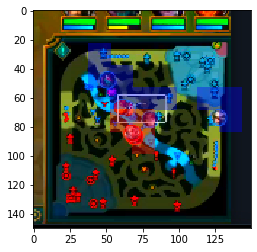

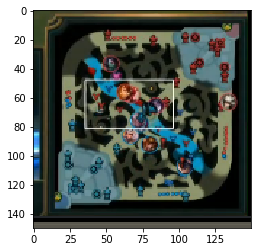

In [76]:
thresh = 0.2
k = random.randint(10, 1000)
draw_preds(k)

In [55]:
learn.export("models/predict_18_apr_2020.pth")
print(learn.data.path)

games_enhanced


In [77]:
learn = load_learner("./games_enhanced/models", "predict_18_apr_2020.pth")

['1;2;b', '1;3;b', '5;3;b', '5;4;b', '5;4;r', '5;5;r', '6;3;b', '7;3;b', '7;7;r', '8;3;b', '8;6;b', '8;7;b', '8;7;r', '8;8;r', '9;6;b', '9;7;b', '9;8;r']


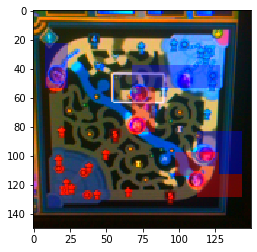

In [79]:
img = "./test/iphone_se_image.png"
fai_img = open_image(img)
predictions = learn.predict(fai_img)[2]
preds = []
img_classes = learn.data.classes

for i in range(len(predictions)):
    if predictions[i] > 0.2:
        preds.append(img_classes[i])
print(preds)
thresh = 0.2
classes = [(int(c.split(";")[0]), int(c.split(";")[1]), c.split(";")[2]) for c in preds]
    
img = PIL.Image.open(img).convert("RGBA")
img = img.resize((150,150))
converter = PIL.ImageEnhance.Color(img)
img = converter.enhance(3)
overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(overlay)
draw_grid(draw, classes)
out = PIL.Image.alpha_composite(img, overlay)
process(out)

# Benchmarking

In [80]:
import time
from io import BytesIO


In [81]:
learn = load_learner("./games_enhanced/models", "predict_18_apr_2020.pth")
# learn = learn.to_fp16()

In [82]:
start_time = time.time()
img = "./test/iphone_se_image.png"
fai_img = open_image(img)

predictions = learn.predict(fai_img)[2]
elapsed_time = time.time() - start_time
print(elapsed_time)

0.022557735443115234


In [83]:
start_time = time.time()
test = ImageList.from_folder("./test")
learn.data.add_test(test)
preds = learn.get_preds(ds_type=DatasetType.Test)
elapsed_time = time.time() - start_time
print(elapsed_time)

2.1096010208129883


In [43]:
learn.get_preds??

In [44]:
im = PIL.Image.open("./test/iphone_se_image.png")

In [45]:
im = im.resize((150,150))
im.save("./test/iphone_se_image150.png")